In [85]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
import re
import numpy as np

from sklearn.model_selection import train_test_split


# Data

In [7]:
file_rawdata = '../raw_data/Combined Data.csv'
file_predictions ='../raw_data/bert_classifier_predictions.csv'
df_raw = pd.read_csv(file_rawdata,index_col=0)
# cleaning (only raw data, the predictions are cleaned when fed to model for prediction, cleaning involved dropna and drop_duplicates)
df_raw = df_raw.dropna(axis=0).reset_index(drop=True)
df_raw = df_raw.drop_duplicates().reset_index(drop=True)
df_pred = pd.read_csv(file_predictions,index_col=0)
print(f'shapes - raw data: {df_raw.shape}, prediction: {df_pred.shape}')
print(f'number of classes - raw data: {df_raw.status.nunique()}, prediction: {df_pred.predictions.nunique()}')
del file_rawdata, file_predictions

shapes - raw data: (51093, 2), prediction: (51093, 3)
number of classes - raw data: 7, prediction: 3


In [25]:
#convert suicidal labels as stress in raw data
map_suicidal_to_stress = {'Anxiety':'Anxiety', 'Stress': 'Stress', 'Normal':'Normal',
'Depression':'Depression','Bipolar':'Bipolar','Personality disorder':'Personality disorder',
'Suicidal':'Stress'}

df_raw['status_relabeled'] = df_raw['status'].map(map_suicidal_to_stress)
print(f'number of classes - raw data: {df_raw.status.nunique()},raw_data relabeled : {df_raw.status_relabeled.nunique()}, prediction: {df_pred.predictions.nunique()}')


number of classes - raw data: 7,raw_data relabeled : 6, prediction: 3


In [32]:
#get indices
ind_only_stress_anx_suici_norm = df_raw['status'].isin(['Stress','Anxiety','Normal'])

In [34]:
#merge raw and predictions
df_merged_all_data = df_raw
df_merged_all_data[['predictions', 'probabilities']] = df_pred[['predictions','probabilities']]
df_merged_all_data.head()
del df_raw , df_pred

In [51]:
# text content
def clean_text(text):
    """Clean and preprocess text"""
    if pd.isna(text):
        return ""
    # Convert to lowercase
    text = str(text).lower()
    # Remove special characters, keep only letters and spaces
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    # Remove extra whitespace
    text = ' '.join(text.split())
        # remove http/https URLs
    text = re.sub(r"http\S+", "", text)
    # remove www.* URLs
    text = re.sub(r"www\.\S+", "", text)
    # remove youtube short links
    text = re.sub(r"youtu\.be\S+", "", text)
    return text.strip()
clean_text('trouble sleeping, confused mind, restless heart. All out of tune')
df_merged_all_data['statement_cleaned'] = df_merged_all_data['statement'].apply(clean_text)

#count characters
df_merged_all_data['length'] = df_merged_all_data['statement'].str.len()
df_merged_all_data['length_cleaned'] = df_merged_all_data['statement_cleaned'].str.len()

#count words
df_merged_all_data['word_num'] = df_merged_all_data['statement'].apply(lambda x: len(x.split()))
df_merged_all_data['word_num_cleaned'] = df_merged_all_data['statement_cleaned'].apply(lambda x: len(x.split()))

df_merged_all_data

,statement,status,status_relabeled,predictions,probabilities,statement_cleaned,length,length_cleaned,word_num,word_num_cleaned
0,oh my gosh,Anxiety,Anxiety,Normal,0.908595,oh my gosh,10,10,3,3
1,"trouble sleeping, confused mind, restless hear...",Anxiety,Anxiety,Anxiety,0.999247,trouble sleeping confused mind restless heart ...,64,61,10,10
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,Anxiety,Anxiety,0.999272,all wrong back off dear forward doubt stay in ...,78,75,14,14
3,I've shifted my focus to something else but I'...,Anxiety,Anxiety,Anxiety,0.984367,i ve shifted my focus to something else but i ...,61,61,11,13
4,"I'm restless and restless, it's been a month n...",Anxiety,Anxiety,Anxiety,0.999310,i m restless and restless it s been a month no...,72,68,14,16
...,...,...,...,...,...,...,...,...,...,...
51088,Anxiety cause faintness when standing up ? As ...,Anxiety,Anxiety,Anxiety,0.996302,anxiety cause faintness when standing up as ti...,130,124,23,20
51089,anxiety heart symptom does anyone else have th...,Anxiety,Anxiety,Anxiety,0.999082,anxiety heart symptom does anyone else have th...,306,296,61,63
51090,Travel Anxiety Hi all! Long time anxiety suffe...,Anxiety,Anxiety,Anxiety,0.980903,travel anxiety hi all long time anxiety suffer...,851,822,159,159
51091,fomo from things i’m not involved in does anyo...,Anxiety,Anxiety,Stress,0.899440,fomo from things i m not involved in does anyo...,891,871,172,182


Text(0, 0.5, 'number of words after cleaning')

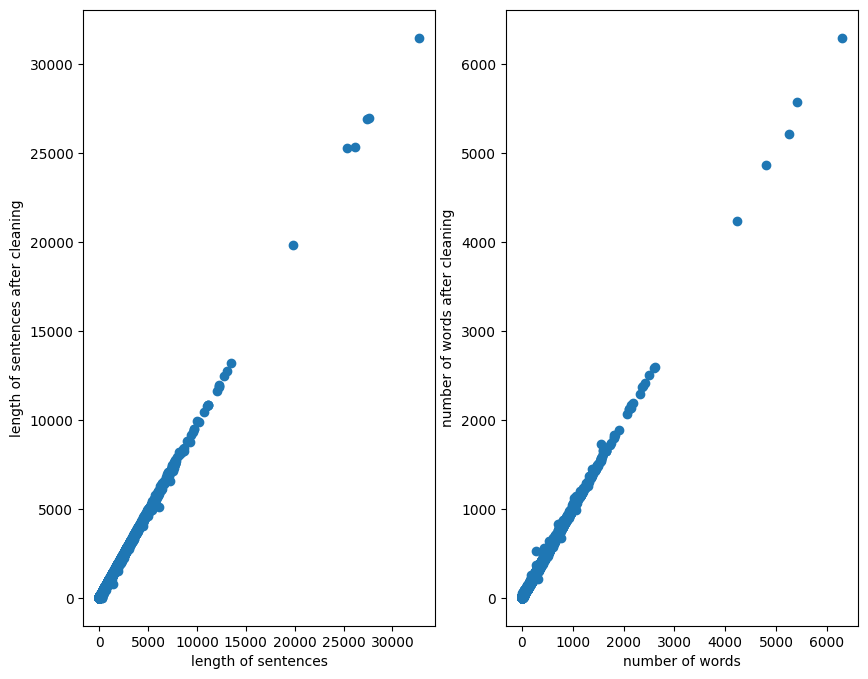

In [54]:
#does cleaning hav an effect ?
fig,axes = plt.subplots(1,2, figsize = (10,8))
axes[0].scatter(df_merged_all_data['length'],df_merged_all_data['length_cleaned'])
axes[0].set_xlabel('length of sentences')
axes[0].set_ylabel('length of sentences after cleaning')

axes[1].scatter(df_merged_all_data['word_num'],df_merged_all_data['word_num_cleaned'])
axes[1].set_xlabel('number of words')
axes[1].set_ylabel('number of words after cleaning')

In [55]:
# separate between stres/anxiety, normal  and others
df_merged_all_stress = df_merged_all_data.loc[ind_only_stress_anx_suici_norm,:]
df_merged_all_others = df_merged_all_data.loc[~ind_only_stress_anx_suici_norm,:]

In [56]:
df_merged_all_stress

,statement,status,status_relabeled,predictions,probabilities,statement_cleaned,length,length_cleaned,word_num,word_num_cleaned
0,oh my gosh,Anxiety,Anxiety,Normal,0.908595,oh my gosh,10,10,3,3
1,"trouble sleeping, confused mind, restless hear...",Anxiety,Anxiety,Anxiety,0.999247,trouble sleeping confused mind restless heart ...,64,61,10,10
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,Anxiety,Anxiety,0.999272,all wrong back off dear forward doubt stay in ...,78,75,14,14
3,I've shifted my focus to something else but I'...,Anxiety,Anxiety,Anxiety,0.984367,i ve shifted my focus to something else but i ...,61,61,11,13
4,"I'm restless and restless, it's been a month n...",Anxiety,Anxiety,Anxiety,0.999310,i m restless and restless it s been a month no...,72,68,14,16
...,...,...,...,...,...,...,...,...,...,...
51088,Anxiety cause faintness when standing up ? As ...,Anxiety,Anxiety,Anxiety,0.996302,anxiety cause faintness when standing up as ti...,130,124,23,20
51089,anxiety heart symptom does anyone else have th...,Anxiety,Anxiety,Anxiety,0.999082,anxiety heart symptom does anyone else have th...,306,296,61,63
51090,Travel Anxiety Hi all! Long time anxiety suffe...,Anxiety,Anxiety,Anxiety,0.980903,travel anxiety hi all long time anxiety suffer...,851,822,159,159
51091,fomo from things i’m not involved in does anyo...,Anxiety,Anxiety,Stress,0.899440,fomo from things i m not involved in does anyo...,891,871,172,182


In [79]:
df_merged_all_others

,statement,status,status_relabeled,predictions,probabilities,statement_cleaned,length,length_cleaned,word_num,word_num_cleaned,correct_prediction
6895,I recently went through a breakup and she said...,Depression,Depression,Stress,0.999720,i recently went through a breakup and she said...,543,538,120,120,1
6896,"I do not know how to navigate these feelings, ...",Depression,Depression,Stress,0.999604,i do not know how to navigate these feelings n...,1510,1479,308,304,1
6897,"So I have been with my bf for 5 months , and h...",Depression,Depression,Stress,0.999663,so i have been with my bf for months and he al...,625,605,131,129,1
6898,I am so exhausted of this. Just when I think I...,Suicidal,Stress,Stress,0.999502,i am so exhausted of this just when i think i ...,1704,1669,342,345,1
6899,I have been severly bullied since i was 5 till...,Depression,Depression,Stress,0.999644,i have been severly bullied since i was till t...,1006,982,196,195,1
...,...,...,...,...,...,...,...,...,...,...,...
50143,Have you ever had “best friend”? From most pos...,Personality disorder,Personality disorder,Normal,0.976742,have you ever had best friend from most posts ...,720,691,139,138,0
50144,Overwhelmed with everything right now I just s...,Personality disorder,Personality disorder,Stress,0.849912,overwhelmed with everything right now i just s...,725,716,133,141,1
50145,"I wanted to be different. So, when I was young...",Personality disorder,Personality disorder,Stress,0.998473,i wanted to be different so when i was younger...,4801,4662,896,936,1
50146,I'm So Sick of Thinking Someone Hates Me When ...,Personality disorder,Personality disorder,Stress,0.997856,i m so sick of thinking someone hates me when ...,677,664,126,132,1


In [68]:
# sanity check
print('number of unique values in -\n')
print(f"stress data:\n from raw data :-{df_merged_all_stress.status_relabeled.nunique()},({df_merged_all_stress.status_relabeled.unique()})")
print(f"from prediction data :-{df_merged_all_stress.predictions.nunique()},({df_merged_all_stress.predictions.unique()})")

print()

print(f"others data:\n from raw data :-{df_merged_all_others.status_relabeled.nunique()},({df_merged_all_others.status_relabeled.unique()})")
print(f"from prediction data :-{df_merged_all_others.predictions.nunique()},({df_merged_all_others.predictions.unique()})")

number of unique values in -

stress data:
 from raw data :-3,(['Anxiety' 'Normal' 'Stress'])
from prediction data :-3,(['Normal' 'Anxiety' 'Stress'])

others data:
 from raw data :-4,(['Depression' 'Stress' 'Bipolar' 'Personality disorder'])
from prediction data :-3,(['Stress' 'Anxiety' 'Normal'])


In [ ]:
# predicted correctly ?
# for stress data
df_merged_all_stress['correct_prediction'] = (df_merged_all_stress['status_relabeled'] == df_merged_all_stress['predictions']).astype(int)
# for other data
df_merged_all_others['correct_prediction'] = (df_merged_all_others['predictions'] != 'Normal').astype(int) # if the prediction is 'Normal' .. thats a wrong prediction

/tmp/ipykernel_169103/1343092845.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged_all_stress['correct_prediction'] = (df_merged_all_stress['status_relabeled'] == df_merged_all_stress['predictions']).astype(int)
/tmp/ipykernel_169103/1343092845.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged_all_others['correct_prediction'] = (df_merged_all_others['predictions'] != 'Normal').astype(int) # if the prediction is normal .. thats a wrong prediction


In [88]:
#split the stress data in test and train
df_merged_all_stress_train,df_merged_all_stress_test = train_test_split(df_merged_all_stress, random_state=42, test_size=0.2)

In [89]:
# all the unseen data by the model
df_merged_all_stress_test, df_merged_all_others

(                                               statement   status  \
 50931  Anxiety at night Anyone’s anxiety worst  at be...  Anxiety   
 33906  Heart anxiety pvc, vt and cpvt Hi there. I wan...  Anxiety   
 41867     going thru town and traffic on bypass is stink   Normal   
 28685  They threw me up against the wall, patted me d...   Stress   
 27498  We need a motel. We need advice. My grandson w...   Stress   
 ...                                                  ...      ...   
 2932   How stupid am I walking 2-3 kilos while fastin...   Normal   
 33277                 but we have the same old problems.   Normal   
 30235        i may know which girl you're talking about.   Normal   
 31263                        don't you ever cheat on me.   Normal   
 2669                           Wei's body hurts all over   Normal   
 
       status_relabeled predictions  probabilities  \
 50931          Anxiety     Anxiety       0.997842   
 33906          Anxiety     Anxiety       0.999027

In [114]:
def statistics_on_length(df,prob_col:str,length_col:str,col_pred:str):
    '''length could be interms of words or in terms of characters
    col_pred is 1 or 0 for correct and wrong prediction'''
    return df.groupby([col_pred]).agg({prob_col:['min','max','mean','std'],length_col:['min','max','mean','std']})

In [115]:
statistics_on_length(df_merged_all_stress_test,'probabilities','length','correct_prediction')

probabilities                               length        \
                             min       max      mean       std    min   max   
correct_prediction                                                            
0                       0.501499  0.999559  0.824865  0.161634      6  2353   
1                       0.511203  0.999848  0.992204  0.035815      3  8389   

                                            
                          mean         std  
correct_prediction                          
0                   451.867470  420.464284  
1                   253.588768  474.088091

In [116]:
statistics_on_length(df_merged_all_others,'probabilities','length','correct_prediction')

probabilities                               length         \
                             min       max      mean       std    min    max   
correct_prediction                                                             
0                       0.456601  0.999778  0.933788  0.119892      3  25302   
1                       0.359217  0.999772  0.979389  0.071134     10  32759   

                                            
                          mean         std  
correct_prediction                          
0                   199.154440  721.595529  
1                   846.524229  978.570250

In [112]:
def plot_correct_pred_and_prob_for_diff_length(df,prob_col:str,length_col:str,col_pred:str,horiz_line_val=0.9,vert_line_val=5000,xlim=None):
    '''length could be interms of words or in terms of characters
    col_pred is 1 or 0 for correct and wrong prediction'''

    # plt.scatter(df[length_col],df[col_pred], label = col_pred)
    # plt.scatter(df[length_col],df[prob_col],c='r',label=prob_col)
    # plt.axhline(horiz_line_val)
    # plt.axvline(vert_line_val)
    # plt.legend()
    # plt.xscale('log')
    sns.scatterplot(df,x=length_col,y=prob_col,hue=col_pred, alpha=0.7)
    plt.xscale('log')
    if xlim is not None:
        plt.xlim(xlim)
    plt.show()

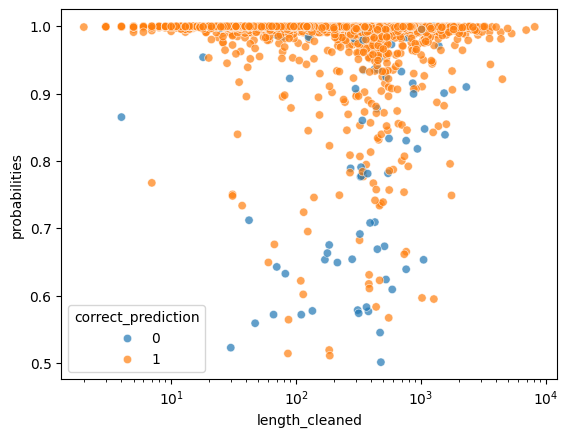

In [121]:
plot_correct_pred_and_prob_for_diff_length(df_merged_all_stress_test,'probabilities','length_cleaned','correct_prediction')

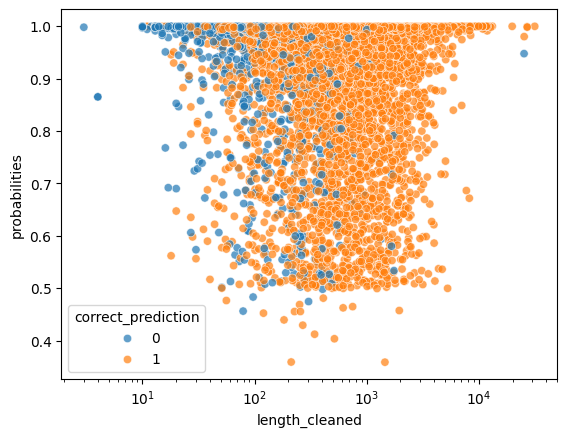

In [120]:
plot_correct_pred_and_prob_for_diff_length(df_merged_all_others,'probabilities','length_cleaned','correct_prediction')

In [ ]:
plot_correct_pred_and_prob_for_diff_length(df_merged_all_others,'probabilities','length','correct_prediction')

# EDA

## distribution of labels

In [ ]:
print(f"\nUnique labels: {data_df['status'].unique()}")
print(f"\nLabel distribution(%):")
print(data_df['status'].value_counts(normalize=True)*100)

# # Visualization
plt.figure(figsize=(10, 6))
data_df['status'].value_counts().plot(kind='bar')
plt.xlabel('Mental Health Status')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45)
plt.show()

## Text content

### function definitions

In [ ]:
def create_word_count_distributions(df, statement_col:str, status_col:str, count_col:str, categories:list,x_lim: None|list = None):
    """Create word count distribution plots for each category

    df : dataframe (with raw statements or after cleaned statements)

    with column names given by
        staement_col : contains statements,
        status_col : contains labels like Anxiety, Normal etc.,
        count_col : numbers showing counts (may be word count or character count) per row,
    categories : categories we are interested in, these categories are also in the status_col
    x_limit : none or a list ([min_value, max_value]) to limit the numbers shown in x axis
    """
    # Create subplots
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()

    # Colors for each category
    # colors = plt.cm.Set3(np.linspace(0, 1, len(categories)))

    for i, category in enumerate(categories):
        if i < len(axes):
            # Filter data for this category
            category_data = df[df[status_col] == category][count_col]

            # Create histogram
            sns.histplot(category_data,ax=axes[i])
            #axes[i].hist(category_data, bins=30, alpha=0.7, color=colors[i], edgecolor='black')
            axes[i].set_title(f'{category.title()} - {count_col} Distribution',
                            fontsize=14, fontweight='bold')
            axes[i].set_xlabel('Number of Words')
            axes[i].set_ylabel('Frequency')

            #limit x axis range
            if x_lim is not None:
                axes[i].set_xlim(x_lim)

            # Add statistics text
            mean_words = category_data.mean()
            max_words = category_data.max()
            min_words = category_data.min()

            stats_text = f'Mean: {mean_words:.1f}\nMax: {max_words}\nMin: {min_words}'
            axes[i].text(0.7, 0.9, stats_text, transform=axes[i].transAxes,
                        bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8),
                        verticalalignment='top', fontsize=10)

    # Hide unused subplots
    for j in range(len(categories), len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

def create_comparative_word_count_boxplot(df, statement_col:str, status_col:str,count_col:str, categories:list):
    """Create box plots comparing word counts across categories

    df : dataframe (with raw statements or after cleaned statements)

    with column names given by
        staement_col : contains statements,
        status_col : contains labels like Anxiety, Normal etc.,
        count_col : numbers showing counts (may be word count or character count) per row,
    categories : categories we are interested in, these categories are also in the status_col

    """

    # Create the plot
    plt.figure(figsize=(14, 8))

    # Box plot
    sns.boxplot(data=df, x=status_col, y=count_col, palette='Set2')
    plt.title('Word Count Distribution Comparison Across Categories',
              fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Category', fontsize=12)
    plt.ylabel('Number of Words', fontsize=12)
    plt.yscale('log')
    plt.xticks(rotation=45)

    # Add mean markers
    means = df.groupby(status_col)[count_col].mean()
    for i in categories:
        plt.scatter(i, means[i], color='red', s=100, marker='o', zorder=5)

    plt.tight_layout()
    plt.show()

def get_top_words_per_category(df, statement_col:str, status_col:str, categories:list, top_n=20) -> dict:
    """Extract top N words for each mental health category

    df : dataframe (with raw statements or after cleaned statements)

    with column names given by
        staement_col : contains statements,
        status_col : contains labels like Anxiety, Normal etc.,
    categories : categories we are interested in, these categories are also in the status_col
    top_n : return top n words
    """


    # def clean_text(text):
    #     """Clean and preprocess text"""
    #     if pd.isna(text):
    #         return ""
    #     # Convert to lowercase
    #     text = str(text).lower()
    #     # Remove special characters, keep only letters and spaces
    #     text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    #     # Remove extra whitespace
    #     text = ' '.join(text.split())
    #     return text

    # categories = df[label_col].unique()
    all_category_words = {}

    print("="*80)
    print("TOP WORDS ANALYSIS BY CATEGORY")
    print("="*80)

    for category in categories:
        print(f"\n--- TOP {top_n} WORDS FOR {category.upper()} ---")

        # Get texts for this category
        category_texts = df[df[status_col] == category][statement_col]

        # Combine
        all_text = ' '.join(category_texts)

        # Split into words and filter
        words = [word for word in all_text.split()]

        # Count words
        word_counts = Counter(words)
        top_words = word_counts.most_common(top_n)

        # Store results
        all_category_words[category] = dict(top_words)

        # Display results
        for i, (word, count) in enumerate(top_words, 1):
            print(f"{i:2d}. {word:<15} ({count:,} times)")
        # Combine texts
        all_text = ' '.join(category_texts)
        print(f"Total unique words in {category}: {len(word_counts):,}")
        print(f"Total words analyzed: {sum(word_counts.values()):,}")

    return all_category_words

def plot_cloud_of_words(df,statement_col:str, status_col:str,category:str):
    """make a cloud of words plot for a given category

    df : dataframe (with raw statements or after cleaned statements)

    with column names given by
        staement_col : contains statements,
        status_col : contains labels like Anxiety, Normal etc.,
    category : category we are interested in, these category is also in the status_col
    top_n : return top n words
    """

    # Get texts for the category over the whole corpus
    category_texts = data_df[data_df[status_col] == category][statement_col]
    combined_text = ' '.join(category_texts.astype(str))

    cloud_of_words = WordCloud(
            width=800,
            height=400,
            background_color='white',
            max_words=100,
            colormap='viridis',  # You can change colors: 'plasma', 'inferno', 'magma'
            relative_scaling=0.5,
            min_font_size=10
        ).generate(combined_text)

fig, axes = plt.subplots(figsize=(15,8))
axes.imshow(cloud_of_words, interpolation='bilinear')
# plt.title(f'{category_name.title()} - Most Common Words',
#               fontsize=20, fontweight='bold', pad=20)
plt.axis('off');

In [ ]:
data_df['num_of_charac'] = data_df['statement'].str.len()
data_df['num_of_words'] = data_df['statement'].apply(lambda x : len(x.strip().split()))
data_df

In [ ]:
data_df.groupby('status')['num_of_words'].agg(['min','max','mean'])

In [ ]:
# calling different functions
create_word_count_distributions(data_df, 'statement', 'status','num_of_words', data_df['status'].unique(),[-10,1000])

In [ ]:
create_comparative_word_count_boxplot(data_df, 'statement', 'status','num_of_words', data_df['status'].unique())
top_words_by_category = get_top_words_per_category(data_df, 'statement', 'status', data_df['status'].unique(),5)


In [ ]:
plot_cloud_of_words(data_df,'statement', 'status','Anxiety')